<a href="https://colab.research.google.com/github/Violetta1998/PyTorch/blob/master/mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2. Многослойный перцептрон
Необходимо реализовать многослойный перцептрон для решения задач классификации. Для реализации можно использовать любые библиотеки и инструменты, которые позволяют выполнить условия данной лабораторной работы



# Необходимо продемонстрировать работу следующих сценариев: 

1) По количеству классов: малое(2-3) - *diabetes.csv* и *dataset2*, среднее(7-10), большое (~30)

2) По разделимости классов: линейно разделимое множество, линейно неразделимое множество (*dataset2*) (средняя площадь пересечения классов 10-20%), линейно неразделимое множество (средняя площадь пересечения классов 50-70%)

3) По качеству обучения: переобучение, недообучение, паралич сети

4) На эталонных множествах с количеством признаков более 5

5) По кодированию ответа в выходном слое

# Графики качества обучения
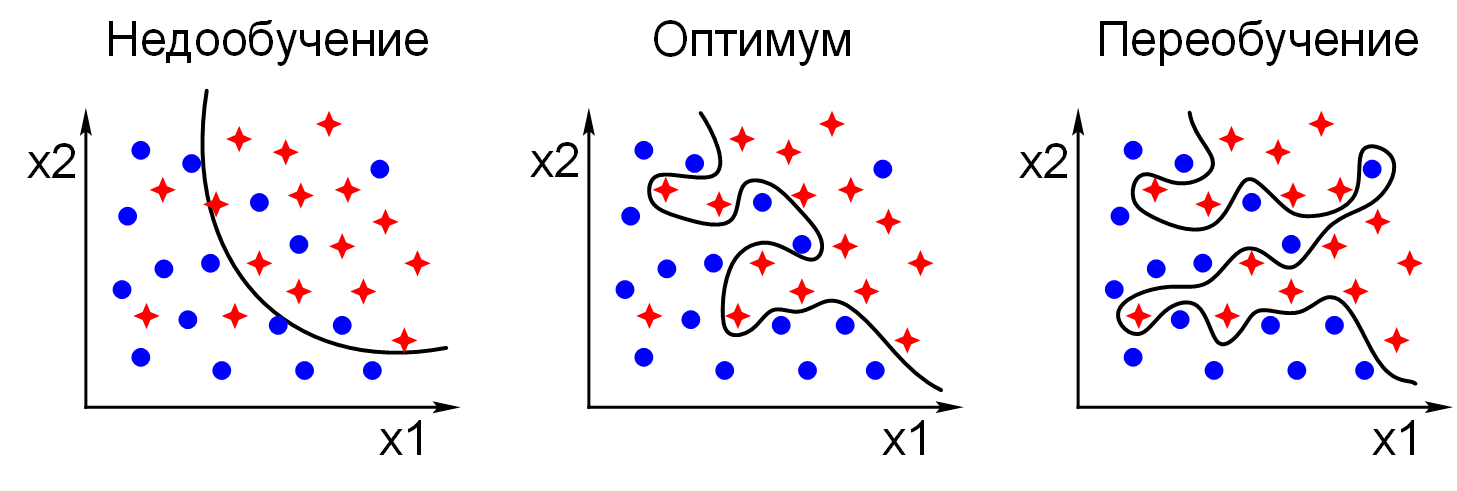

# Причины переобучения
> слишком мало данных для обучения либо слишком много нейронов и синапсов в ИНС – модель запомнила все варианты из обучающей выборки и, таким образом, утратила возможность обобщения, выдавая запомненные варианты вместо предсказаний;

> слишком долгое обучение – модель находит закономерности в шуме

> плохо подготовленные данные в обучающей выборке могут привести к тому, что модель будет давать большую ошибку на новых данных, которые не участвовали в обучении.

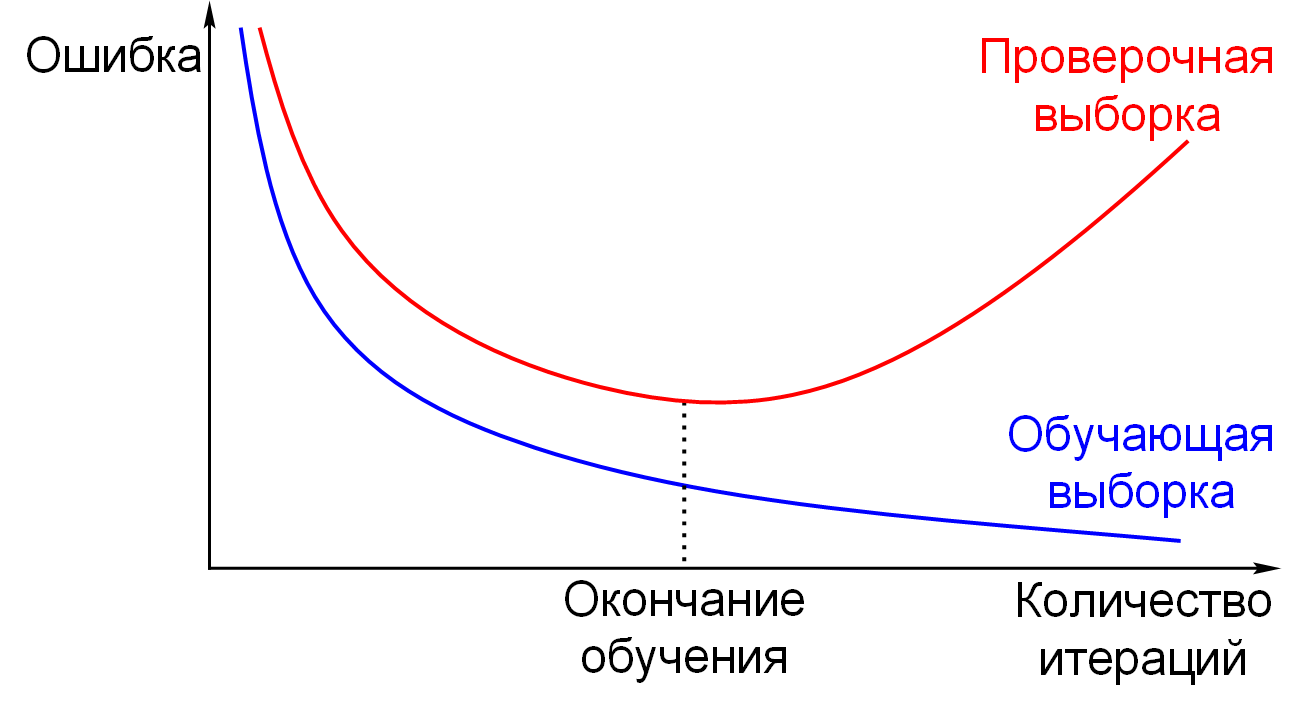

# Недообучение
Недообучение - явление, при котором ошибка обученной модели оказывается слишком большой. Недообучение возникает при использовании слишком простых моделей, как правило, с малым количеством нейронов и синапсов, либо при прекращении процесса обучения до достижения состояния с достаточно малой ошибкой, либо при неудачной обучающей выборке.

# Паралич сети
Паралич сети возникает при неограниченном увеличении весов. Аргумент
функции активации попадает в область, где функция активации имеет горизонтальную асимптоту, производная функции активации стремится к нулю, в результате веса не модифицируются, и сеть «застревает» в таком положении.

In [0]:
import torch
import numpy as np
from torch import from_numpy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# Загрузка данных из diabetes.csv
Данные содержат 8 атрибутов и 2 класса - 0 и 1.

In [0]:
xy = np.loadtxt('./diabetes.csv',
                        delimiter=',', dtype=np.float32)
np.random.shuffle(xy)
#x_data = torch.FloatTensor(from_numpy(xy[:, 0:-1])).to(device)
#y_data = torch.FloatTensor(from_numpy(xy[:, [-1]])).to(device)

X_train, X_test, X_val = np.split(xy, [int(.8 * len(xy)), int(.9 * len(xy))])

x_train = torch.FloatTensor(from_numpy(X_train[:, 0:-1])).to(device)
x_test = torch.FloatTensor(from_numpy(X_test[:, 0:-1])).to(device)
x_val = torch.FloatTensor(from_numpy(X_val[:, 0:-1])).to(device)

y_train = torch.FloatTensor(from_numpy(X_train[:, [-1]])).to(device)
y_test = torch.FloatTensor(from_numpy(X_test[:, [-1]])).to(device)
y_val = torch.FloatTensor(from_numpy(X_val[:, [-1]])).to(device)


# Создание модели
1 слой - линейный (применяет линейное преобразование к входным данным )

> 8 нейронов на входе, 4 на выходе

> функция активации - сигмоидальная

> Предусмотрен единичный вход


2 слой - линейный


> 4 нейрона на входе, 1 на выходе

> функция активации - сигмоидальная

> Предусмотрен единичный вход



In [0]:
# nn layers
linear1 = torch.nn.Linear(8, 4, bias=True)
linear2 = torch.nn.Linear(4, 1, bias=True)
sigmoid = torch.nn.Sigmoid()
relu = torch.nn.ReLU()

In [0]:
# model
model = torch.nn.Sequential(linear1, sigmoid, linear2, sigmoid).to(device)

In [0]:
#зададим функцию потерь и оптимизатор
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

Функция для вычисления метрик модели - accuracy, precision, recall


In [0]:
def find_metrics(model, x_data, y_data):
  with torch.no_grad():
      hypothesis = model(x_train)
      predicted = (hypothesis > 0.5).float()
      
      precision = precision_score(y_train, predicted)
      recall = recall_score(y_train, predicted)
      accuracy_m = accuracy_score(y_train, predicted)
      accuracy = (predicted == y_train).float().mean()
      
      print('\nAccuracy: ', accuracy_m, ' | Precision: ', precision, ' | Recall: ', recall)
      return accuracy, precision, recall

In [824]:
accuracy=[]
precision=[]
recall=[]
error = []
error_val = []
epochs = 10000
for step in range(epochs):
    #===Train data===#
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)

    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    error.append(loss.item())

    #===Validation data===#
    model.eval()
    optimizer.zero_grad()
    y_pred = model(x_val)

    loss = criterion(y_pred, y_val)
    loss.backward()
    optimizer.step()
    error_val.append(loss.item())

    if step % 1000 == 0:
      model.eval()
      print("\nStep: ", step,' ', " | Loss: ", loss.item())
      acc, pr, rc = find_metrics(model, x_train, y_train)
      accuracy.append(acc)
      precision.append(pr)
      recall.append(rc)


Step:  0    | Loss:  0.7376057505607605

Accuracy:  0.3542009884678748  | Precision:  0.0  | Recall:  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Step:  1000    | Loss:  0.5221546292304993

Accuracy:  0.7693574958813838  | Precision:  0.771551724137931  | Recall:  0.9132653061224489

Step:  2000    | Loss:  0.5111992359161377

Accuracy:  0.7644151565074135  | Precision:  0.7888631090487239  | Recall:  0.8673469387755102

Step:  3000    | Loss:  0.5045232176780701

Accuracy:  0.7677100494233937  | Precision:  0.7911832946635731  | Recall:  0.8698979591836735

Step:  4000    | Loss:  0.4913248121738434

Accuracy:  0.7677100494233937  | Precision:  0.7952941176470588  | Recall:  0.8622448979591837

Step:  5000    | Loss:  0.4690280258655548

Accuracy:  0.7660626029654036  | Precision:  0.7920560747663551  | Recall:  0.8647959183673469

Step:  6000    | Loss:  0.44596365094184875

Accuracy:  0.7578253706754531  | Precision:  0.788235294117647  | Recall:  0.8545918367346939

Step:  7000    | Loss:  0.42931485176086426

Accuracy:  0.7528830313014827  | Precision:  0.7867298578199052  | Recall:  0.8469387755102041

Step:  8000    | Lo

Построим графики полученных метрик с помощью библиотеки *matplotlib*

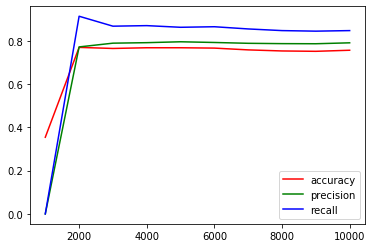

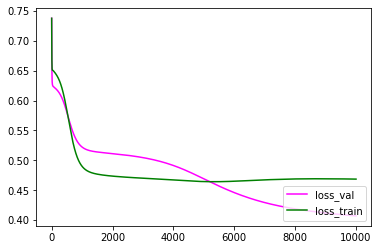

In [825]:
import matplotlib.pyplot as plt
step = 1000
x = [i for i in range(step, epochs+step, step)]
plt.plot(x, accuracy, color='red', label='accuracy')
plt.plot(x, precision, color = 'green', label='precision')
plt.plot(x, recall, color = 'blue', label='recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

x = [i for i in range(epochs)]
plt.plot(x, error_val, color = 'magenta', label='loss_val')
plt.plot(x, error, color = 'green', label='loss_train')
plt.legend(loc='lower right')
plt.show()

# Сгенерируем новые данные dataset_2
Кол-во классов: 4, кол-во аттрибутов: 2, линейно-неразделимое множество

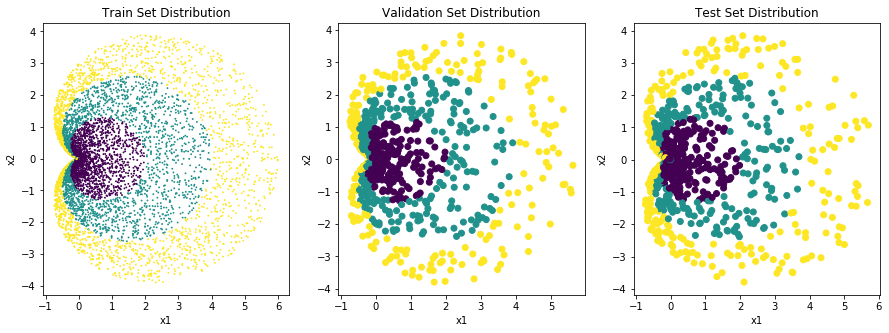

In [826]:
# Сгенерируем датасет
r = np.random.rand(10000)*3
theta = np.random.rand(10000)*2*np.pi
y = r.astype(int)
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# Разделение на train, val, test
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# Выведем график данных для каждой выборки
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

In [0]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [0]:
loss_cel = nn.CrossEntropyLoss()
model = MLPModel() 
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [829]:
epochs = 1000
step = 200
def train(model,epochs,step, train_X, train_y, val_X, val_y):
  accuracy = []
  precision = []
  recall = []
  error = []
  error_val = []
  for i in range(epochs):
    #===Train data===#
    model.train()
    optimizer.zero_grad()
    
    input_x = torch.tensor(train_X).float()
    true_y = torch.tensor(train_y).long()
    pred_y = model(input_x)
    loss = loss_cel(pred_y, true_y)
    loss.backward()
    optimizer.step()
    error.append(loss.item())

    #===Validation data===#
    model.eval()
    optimizer.zero_grad()
    
    input_x = torch.tensor(val_X).float()
    true_y = torch.tensor(val_y).long()
    pred_y = model(input_x)
    loss = loss_cel(pred_y, true_y)
    loss.backward()
    optimizer.step()
    error_val.append(loss)

    if i % step == 0:
        model.eval()
        optimizer.zero_grad()
        input_x = torch.tensor(test_X).float()
        true_y = torch.tensor(test_y).long()
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        acc = accuracy_score(true_y, pred_y)
        pr = precision_score(true_y, pred_y, average='weighted')
        rc = recall_score(true_y, pred_y, average='weighted')
        
        accuracy.append(acc)
        precision.append(pr)
        recall.append(rc)
        
        print("\nEpoch: ", i, "| Accuracy: ", acc, "| Precision: ", pr, "| Recall: ", rc, "| Loss: ", loss.item())
  return accuracy, precision, recall, error, error_val
accuracy, precision, recall, error, error_val = train(model, epochs,step, train_X, train_y, val_X, val_y)


Epoch:  0 | Accuracy:  0.398 | Precision:  0.3970822758007566 | Recall:  0.398 | Loss:  1.0533303022384644

Epoch:  200 | Accuracy:  0.772 | Precision:  0.7807671711314255 | Recall:  0.772 | Loss:  0.6268040537834167

Epoch:  400 | Accuracy:  0.789 | Precision:  0.794237219304036 | Recall:  0.789 | Loss:  0.5621922016143799

Epoch:  600 | Accuracy:  0.798 | Precision:  0.8028474862803182 | Recall:  0.798 | Loss:  0.5303505659103394

Epoch:  800 | Accuracy:  0.814 | Precision:  0.8193397774314222 | Recall:  0.814 | Loss:  0.5090000033378601


[0.398, 0.772, 0.789, 0.798, 0.814]


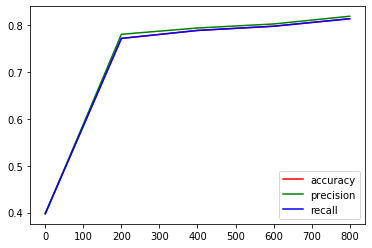

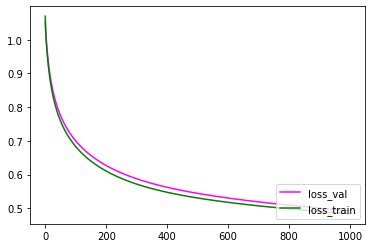

In [830]:
def plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error):
  x = [i for i in range(0, epochs, step)]
  print(accuracy)
  plt.plot(x, accuracy, color='red', label='accuracy')
  plt.plot(x, precision, color = 'green', label='precision')
  plt.plot(x, recall, color = 'blue', label='recall')
  plt.legend(loc='lower right')
  plt.show()
  plt.close()

  x = [i for i in range(epochs)]
  plt.plot(x, error_val, color = 'magenta', label='loss_val')
  plt.plot(x, error, color = 'green', label='loss_train')
  plt.legend(loc='lower right')
  plt.show()

plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error)

# Сгенерируем новые данные dataset_3 
Кол-во классов: 10, линейно-разделимое множество

In [0]:
from sklearn.datasets import make_blobs
def generate_center_clusters(classes_numb = 5,
                     low_bound = -100,
                     high_bound = 100,
                     intercluster_dist = 5,
                     dim = 3,
                     low_bound_points_in_cluster = 150,
                     high_bound_points_in_cluster = 200):
    
    low_bound = low_bound  / (10/classes_numb)
    high_bound = high_bound  / (10/classes_numb)
    center_list = []
    center_list.append(np.array(np.random.uniform(low_bound, high_bound, dim)))
    for i in range(classes_numb-1):
        flag_correct = False
        while flag_correct == False: 
            flag_correct = True
            point_coord = np.array(np.random.uniform(low_bound, high_bound, dim))
            for i in range(len(center_list)):
                flag_correct *= np.linalg.norm(center_list[i]-point_coord) > intercluster_dist
        center_list.append(point_coord)
    return center_list, dim, intercluster_dist

def generate_data(center_list,
                  dim,
                  intercluster_dist,
                  low_bound_points_in_cluster=150,
                  high_bound_points_in_cluster=500,
                  alpha_coef=0.0):
    cluster_std = intercluster_dist * (0.66 + alpha_coef*dim) 
    X, Y = make_blobs(n_samples=np.random.randint(low_bound_points_in_cluster, high_bound_points_in_cluster, len(center_list)),
                   n_features=dim,
                   centers=center_list,
                   cluster_std=cluster_std)
    return X, Y, alpha_coef

def print_clustering(X,Y):
    plt.figure(figsize=(15, 6))
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k')

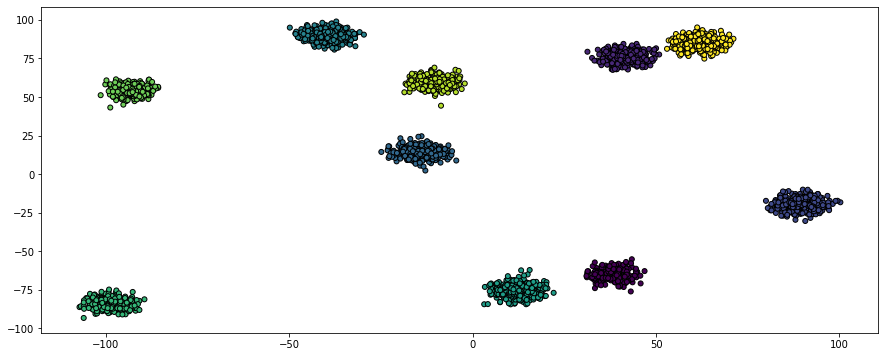

In [832]:
X, y, alpha_coef = generate_data(*generate_center_clusters(classes_numb=10, dim=2), alpha_coef=0)
print_clustering(X, y)

In [0]:
p1 = int(len(X)*0.7)
p2 = int(len(X)*0.8)
train_X, train_y = X[:p1, :], y[:p1]
val_X, val_y = X[p1:p2, :], y[p1:p2]
test_X, test_y = X[p2:, :], y[p2:]


In [0]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [0]:
loss_cel = nn.CrossEntropyLoss()
model = MLPModel() 
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [836]:
epochs = 1000
step = 200
accuracy, precision, recall, error, error_val = train(model, epochs, step, train_X, train_y, val_X, val_y)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch:  0 | Accuracy:  0.23553719008264462 | Precision:  0.15229581018463076 | Recall:  0.23553719008264462 | Loss:  316.4688720703125

Epoch:  200 | Accuracy:  0.9889807162534435 | Precision:  0.9899185276361292 | Recall:  0.9889807162534435 | Loss:  0.03486080840229988

Epoch:  400 | Accuracy:  0.9944903581267218 | Precision:  0.9946518631236415 | Recall:  0.9944903581267218 | Loss:  0.023179728537797928

Epoch:  600 | Accuracy:  0.9944903581267218 | Precision:  0.9946518631236415 | Recall:  0.9944903581267218 | Loss:  0.02292746864259243

Epoch:  800 | Accuracy:  0.9944903581267218 | Precision:  0.9946518631236415 | Recall:  0.9944903581267218 | Loss:  0.0220499224960804


[0.23553719008264462, 0.9889807162534435, 0.9944903581267218, 0.9944903581267218, 0.9944903581267218]


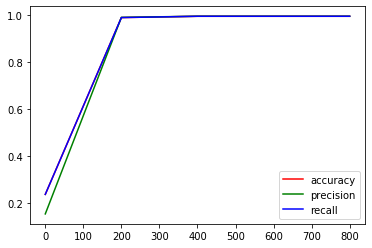

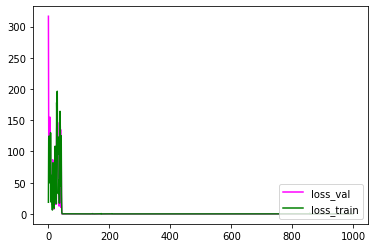

In [837]:
plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error)

# Сгенерируем новые данные dataset_4
Кол-во классов: 30, кол-во атрибутов: 2, линейно-неразделимое
Площадь пересечения >50%

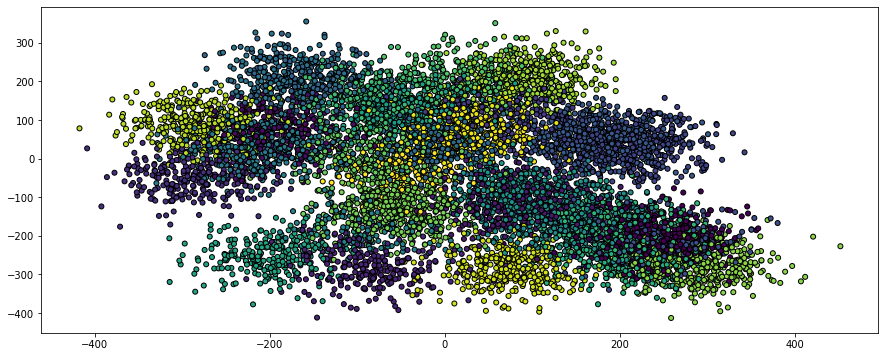

In [848]:
X, y, alpha_coef = generate_data(*generate_center_clusters(classes_numb=30, dim=2), alpha_coef=4)
print_clustering(X, y)

In [0]:
p1 = int(len(X)*0.7)
p2 = int(len(X)*0.8)
train_X, train_y = X[:p1, :], y[:p1]
val_X, val_y = X[p1:p2, :], y[p1:p2]
test_X, test_y = X[p2:, :], y[p2:]


In [0]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=30, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=30)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [0]:
loss_cel = nn.CrossEntropyLoss()
model = MLPModel() 
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [852]:
epochs = 1000
step = 100
accuracy, precision, recall, error, error_val = train(model, epochs, step, train_X, train_y, val_X, val_y)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch:  0 | Accuracy:  0.14526854219948848 | Precision:  0.03413335225080228 | Recall:  0.14526854219948848 | Loss:  253.0833740234375

Epoch:  100 | Accuracy:  0.329923273657289 | Precision:  0.2913235632062357 | Recall:  0.329923273657289 | Loss:  1.8414852619171143

Epoch:  200 | Accuracy:  0.39335038363171354 | Precision:  0.3643547146743553 | Recall:  0.39335038363171354 | Loss:  1.5986436605453491

Epoch:  300 | Accuracy:  0.3969309462915601 | Precision:  0.36580457329943183 | Recall:  0.3969309462915601 | Loss:  1.5326216220855713

Epoch:  400 | Accuracy:  0.42762148337595907 | Precision:  0.3827424444313661 | Recall:  0.42762148337595907 | Loss:  1.5250569581985474

Epoch:  500 | Accuracy:  0.40051150895140664 | Precision:  0.352905132070525 | Recall:  0.40051150895140664 | Loss:  1.5024464130401611

Epoch:  600 | Accuracy:  0.4092071611253197 | Precision:  0.36782495797856757 | Recall:  0.4092071611253197 | Loss:  1.48240327835083

Epoch:  700 | Accuracy:  0.4363171355498721 

[0.14526854219948848, 0.329923273657289, 0.39335038363171354, 0.3969309462915601, 0.42762148337595907, 0.40051150895140664, 0.4092071611253197, 0.4363171355498721, 0.42404092071611255, 0.40664961636828645]


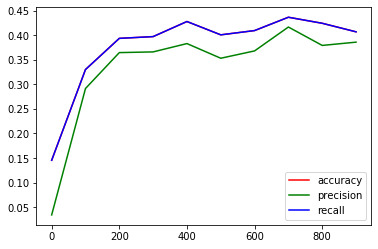

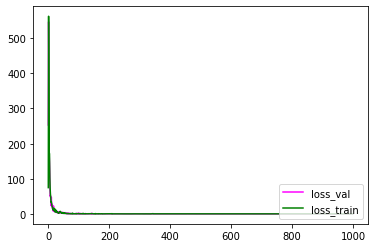

In [853]:
plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error)

# Сгенерируем новые данные - dataset_5
Кол-во классов: 10, кол-во аттрибутов: 2, линейно-нераздилимое (площадь пересечения 20-30%)

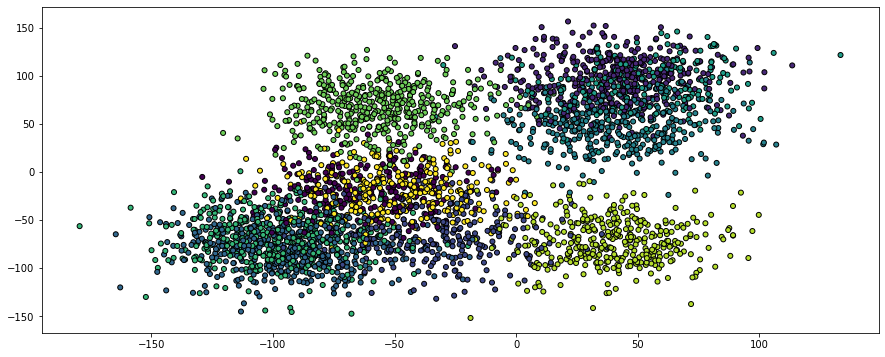

In [867]:
X, y, alpha_coef = generate_data(*generate_center_clusters(classes_numb=10, dim=2), alpha_coef=2)
print_clustering(X, y)

In [0]:
p1 = int(len(X)*0.7)
p2 = int(len(X)*0.8)
train_X, train_y = X[:p1, :], y[:p1]
val_X, val_y = X[p1:p2, :], y[p1:p2]
test_X, test_y = X[p2:, :], y[p2:]


In [0]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=100)
        self.linear3 = nn.Linear(in_features=100, out_features=10)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.relu(x)
        return x

In [0]:
loss_cel = nn.CrossEntropyLoss()
model = MLPModel() 
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 100000 #для переобучение
step = 500
accuracy, precision, recall, error, error_val = train(model, epochs, step, train_X, train_y, val_X, val_y)
plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error)

# Возьмем эталонное множество - iris.dataset

In [0]:
xy = np.loadtxt('./iris.txt',
                        delimiter=',', dtype=np.float32)
np.random.shuffle(xy)

X_train, X_test, X_val = np.split(xy, [int(.8 * len(xy)), int(.9 * len(xy))])

x_train = torch.FloatTensor(from_numpy(X_train[:, 0:-1])).to(device)
x_test = torch.FloatTensor(from_numpy(X_test[:, 0:-1])).to(device)
x_val = torch.FloatTensor(from_numpy(X_val[:, 0:-1])).to(device)

y_train = torch.FloatTensor(from_numpy(X_train[:, [-1]])).to(device)
y_test = torch.FloatTensor(from_numpy(X_test[:, [-1]])).to(device)
y_val = torch.FloatTensor(from_numpy(X_val[:, [-1]])).to(device)


In [0]:
# nn layers
linear1 = torch.nn.Linear(4, 100, bias=True)
linear2 = torch.nn.Linear(100, 3, bias=True)
sigmoid = torch.nn.Sigmoid()

# model
model = torch.nn.Sequential(linear1, sigmoid, linear2, sigmoid).to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 10000
step = 100

In [943]:
accuracy=[]
error = []
error_val = []
for i in range(epochs):
    #===Train data===#
    model.train()
    optimizer.zero_grad()
    
    input_x = torch.tensor(x_train).float()
    true_y = torch.tensor(y_train).long()
    pred_y = model(input_x)
    loss = loss_cel(pred_y, true_y.squeeze(1).long())
    loss.backward()
    optimizer.step()
    error.append(loss.item())

    #===Validation data===#
    model.eval()
    optimizer.zero_grad()
    y_pred = model(x_val)

    loss = criterion(y_pred, y_val.squeeze(1).long())
    loss.backward()
    optimizer.step()
    error_val.append(loss.item())

    if i % 1000 == 0:
      model.eval()
      print("\nEpoch: ", i, "| Loss_train: ", error[i], "| Loss_val: ", error_val[i] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.



Epoch:  0 | Loss_train:  1.1097922325134277 | Loss_val:  1.0621198415756226

Epoch:  1000 | Loss_train:  0.7016043066978455 | Loss_val:  0.6890278458595276

Epoch:  2000 | Loss_train:  0.6819422245025635 | Loss_val:  0.6749871373176575

Epoch:  3000 | Loss_train:  0.6758252382278442 | Loss_val:  0.6697124242782593

Epoch:  4000 | Loss_train:  0.6729384064674377 | Loss_val:  0.666731595993042

Epoch:  5000 | Loss_train:  0.6712684631347656 | Loss_val:  0.6647593975067139

Epoch:  6000 | Loss_train:  0.6701713800430298 | Loss_val:  0.6633489727973938

Epoch:  7000 | Loss_train:  0.6693825125694275 | Loss_val:  0.6622911691665649

Epoch:  8000 | Loss_train:  0.6687778830528259 | Loss_val:  0.6614700555801392

Epoch:  9000 | Loss_train:  0.6682912111282349 | Loss_val:  0.6608145833015442


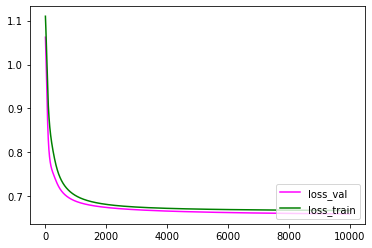

In [944]:
x = [i for i in range(epochs)]
plt.plot(x, error_val, color = 'magenta', label='loss_val')
plt.plot(x, error, color = 'green', label='loss_train')
plt.legend(loc='lower right')
plt.show()